In [3]:
data_path = 'Z:\DEV\weather-forcast\CCTV_DATA'
train_label_data_path = data_path+'\data\Training\label'
val_label_data_path = data_path+'\data\Validation\label'
train_train_data_path = data_path+'\data\Training\\train'
val_train_data_path = data_path+'\data\Validation\\train'

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
# import albumentations as A
from torchvision import models
from PIL import Image
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
# from albumentations.pytorch.transforms import ToTensorV2
# from pytorch_grad_cam.gradcam import CAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchray.attribution.grad_cam import grad_cam

C:\Users\jhp12\AppData\Local\Temp\ipykernel_25744\2492835917.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
r_test_df = pd.read_csv(data_path+'/final_test_df.csv')
r_test_df_label = pd.read_csv(data_path+'/final_test_df_label.csv')
r_test_df = r_test_df.drop(columns=['Unnamed: 0'])
r_test_df_label = r_test_df_label.drop(columns=['Unnamed: 0'])


dir_val = "Z:/DEV/weather-forcast/CCTV_DATA/data/Validation/img/"

val_file_paths = [os.path.join(dir_val, file_name + '.jpg') for file_name in r_test_df['filename']]
val_labels = r_test_df_label['weather']

image_size = (640, 480)
all_images = []
all_labels = []
cnt = 0
for file_path, label in zip(val_file_paths[::10], val_labels[::10]):
    img = Image.open(file_path)
    img_resized = img.resize(image_size)
    img_array = np.array(img_resized, dtype=np.uint8)
    all_images.append(img_array)
    all_labels.append(label)
    cnt+=1
    print(cnt)

In [7]:
all_labels = pd.get_dummies(all_labels)

_, X_test, _, y_test = train_test_split(
    all_images, all_labels, test_size=0.99, stratify=all_labels, random_state=42
)

test_data = {"numpy": np.array(X_test), "label": y_test}

In [21]:
# dataset class
class dataset(Dataset):
    def __init__(self, data):
        self.x = data["numpy"]
        self.y = data["label"]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # 추가적인 전처리나 변환을 여기에 추가할 수 있습니다.
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        single_x = self.x[index]
        single_y = self.y.iloc[index]
        single_y = torch.tensor(single_y)
        augmented = self.transform(single_x)
        normalized = self.normalization(augmented)
        

        # normalized = self.normalization(augmented)
        return normalized, single_y

    def normalization(self, tensor):
        normalized_tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
        return normalized_tensor


test_dataset = dataset(test_data)
test_batch = 1
test_dataloader = DataLoader(test_dataset, batch_size=test_batch)

In [68]:
class_num = 3
class network(nn.Module):
    def __init__(self, class_num):
        super().__init__()
        self.class_num = class_num
        self.init = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1, 1))
        self.model = models.resnet18(pretrained=True)
        self.gradlayer = self.model.layer4[-1]
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(
            in_features=self.num_ftrs, out_features=self.class_num
        )
        
        # self.softmax = torch.nn.Softmax(dim=1)
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        output = self.init(x)
        output = self.model(output)
        # output = self.softmax(output)
        # output = self.sigmoid(output)

        return output
        
        
model = network(class_num=class_num)
print("###모델 정의 완료(resnet18)###\n", summary(model))

###모델 정의 완료(resnet18)###
Layer (type:depth-idx)                        Param #
network                                       --
├─Conv2d: 1-1                                 12
├─ResNet: 1-2                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,08

c:\Users\jhp12\anaconda3\envs\iist_weather\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jhp12\anaconda3\envs\iist_weather\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


C:\Users\jhp12\AppData\Local\Temp\ipykernel_25744\4053658067.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_y = torch.tensor(single_y)


True


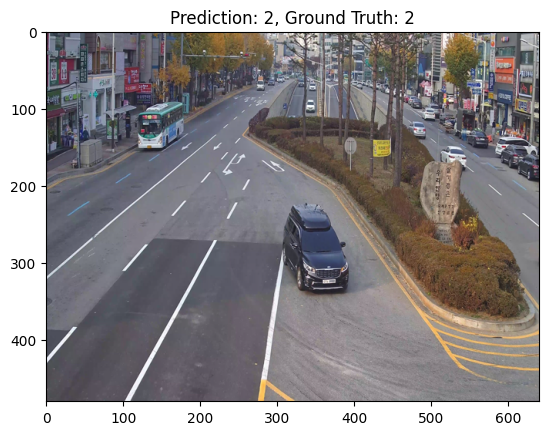

False
False
False
True
True
True
False
True
True
True
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
True
False
False
False
False
False
True
False
False
False
False
False
True
False
False
True
False
False
True
True
True
False


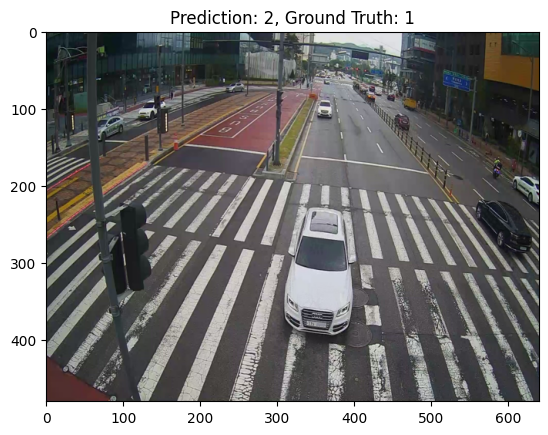

False
False
False
False
False
True
False
False
False
False
True
True
True
True
False
False
False
False
True
True
True
False
False
False
False
False
True
False
True
False
True
False
False
False
False
False
True
True
False
False
False
True
False
True
True
True
True
False
True
False


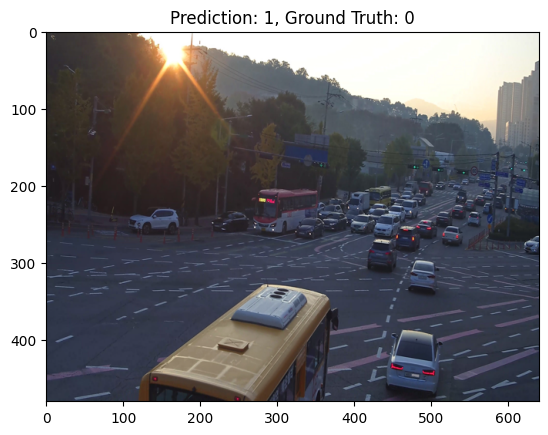

False
False
True
False
False
True
True
False
True
False
True
True
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
True
False


Exception ignored in: <function BaseCAM.__del__ at 0x000001CB6970FF70>
Traceback (most recent call last):
  File "c:\Users\jhp12\anaconda3\envs\iist_weather\lib\site-packages\pytorch_grad_cam\base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'
Exception ignored in: <function BaseCAM.__del__ at 0x000001CB6970FF70>
Traceback (most recent call last):
  File "c:\Users\jhp12\anaconda3\envs\iist_weather\lib\site-packages\pytorch_grad_cam\base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'
Exception ignored in: <function BaseCAM.__del__ at 0x000001CB6970FF70>
Traceback (most recent call last):
  File "c:\Users\jhp12\anaconda3\envs\iist_weather\lib\site-packages\pytorch_grad_cam\base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribut

False
False
True
False
True
False
False
False
False
False
False


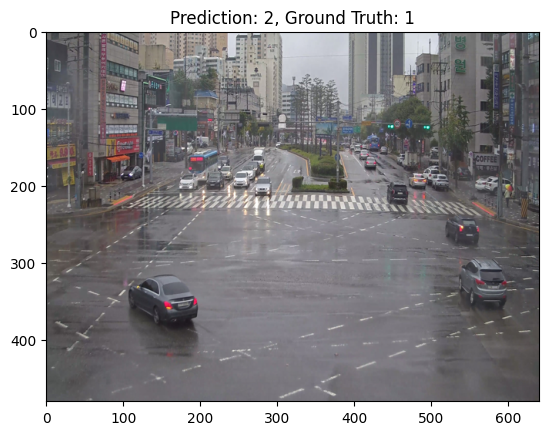

False
False
False
False
True
True
True
False
False
False
False
False
True
False
False
False
True
True
False
False
False
False
True
False
True
False
True
False
False
False
False
True
True
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
True
False


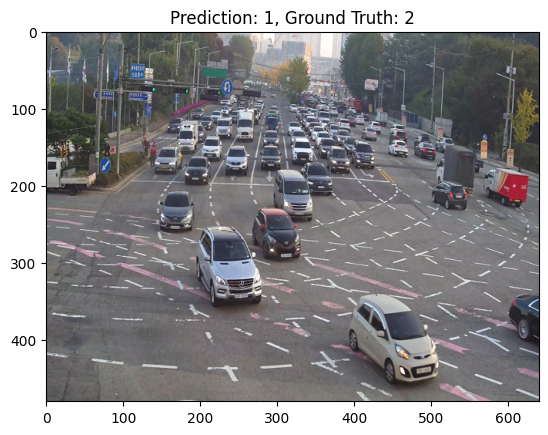

False
False
False
False
False
False
False
True
True
True
False
False
False
False
True
False
False
False
False
False
True
True
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
True
True
False
True
False
False
False
True
False
True


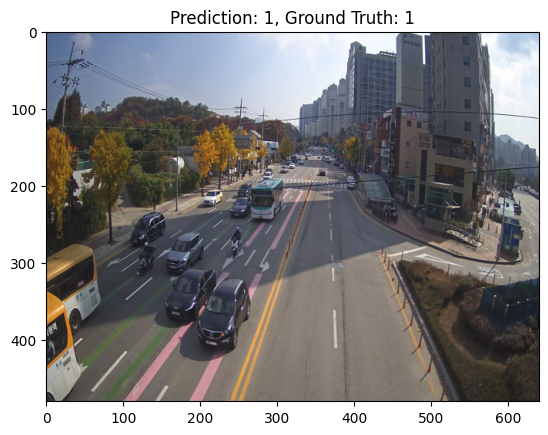

True
True
False
False
True
True
True
False
False
True
False
False
False
True
False
False
False
True
True
True
False
False
False
True
True
True
True
True
False
False
True
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
True
True
False
True


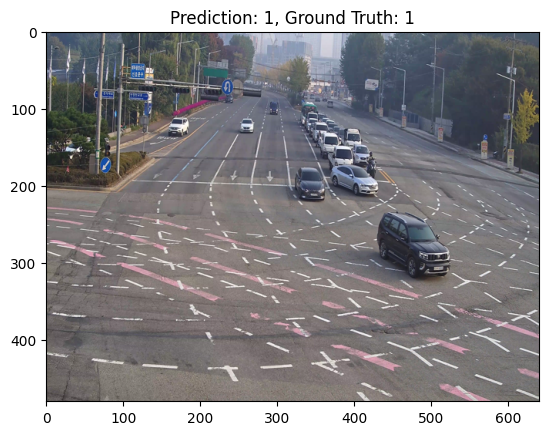

False
False
False
False
False
True
True
False
False
True
False
True
True
True
False
True
False
True
False
False
True
False
False
False
False
False
False
False
False
False
Test 결과 OK 개수:111, NG개수:220, 정확도 : 0.33534743202416917


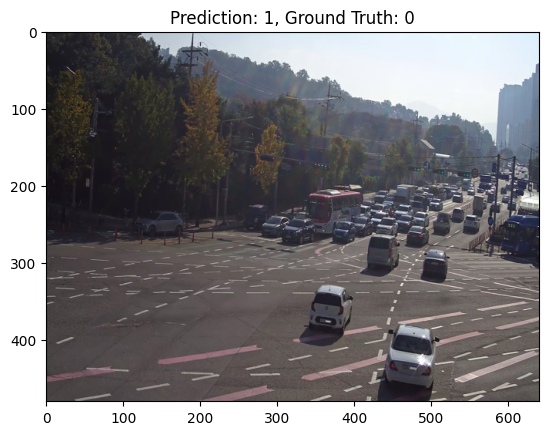

In [69]:
# Z:/DEV/weather-forcast/CCTV_DATA/data/gpu_test_epoch12
model_test_path = 'Z:/DEV/weather-forcast/CCTV_DATA/data/gpu_test_epoch12/'
save_path = "Z:/DEV/weather-forcast/CCTV_DATA/data/gpu_test_epoch13.pt"
test_results = []
grad_image = []
model = network(class_num=class_num)
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()


model_test_cnt = 0
for i, batch_index in enumerate(test_dataloader):
    
    inputs, labels = batch_index
    inputs = inputs.float()
    labels = labels[0]
    result1 = torch.where(labels == labels.max())[0]

    with torch.no_grad():
        outputs = model(inputs)[0]
        result2 = torch.where(outputs == outputs.max())[0]

    test_result = True if result1 == result2 else False
    print(test_result)
    test_results.append(test_result)
    plt.imshow(inputs.squeeze().permute(1, 2, 0).cpu().numpy())  # 이미지를 CPU로 이동하여 출력
    plt.title(f"Prediction: {result2.item()}, Ground Truth: {result1.item()}")
    plt.savefig(model_test_path+'output_'+str(model_test_cnt)+'.png') 
    if model_test_cnt % 50 == 0:    
        # 결과 이미지 출력   
        plt.show()
    elif model_test_cnt > 2000: break
    else: pass
    model_test_cnt += 1

ok = test_results.count(True)
ng = test_results.count(False)
accuracy = ok / (ok + ng)
print(f"Test 결과 OK 개수:{ok}, NG개수:{ng}, 정확도 : {accuracy}")
with open(model_test_path+'acc.txt', "w") as f:
    f.write(f"Test 결과 OK 개수: {ok}\n")
    f.write(f"NG 개수: {ng}\n")
    f.write(f"정확도: {accuracy}\n")

In [39]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Grad-CAM function definition (with layer absence handling)
def apply_grad_cam(model, target_layer_name):
    """
    Applies Grad-CAM to the specified layer of the given model,
    handling potential layer absence gracefully.

    Args:
        model: PyTorch model.
        target_layer_name: Name of the layer to use for Grad-CAM (e.g., "layer4.2.conv3").

    Returns:
        A GradCAM object if the layer is found, or None otherwise.
    """

    target_layer = None
    for name, module in model.named_modules():
        if name == target_layer_name:
            target_layer = module
            break

    if target_layer is None:
        print(f"Warning: Layer '{target_layer_name}' not found in the model.")
        return None  # Or raise an exception if appropriate

    # Create and return the GradCAM object
    return GradCAM(model=model, target_layers=[target_layer])


# Grad-CAM application and visualization
model_test_path = 'Z:/DEV/weather-forcast/CCTV_DATA/data/gpu_test_epoch14/'
test_results = []
grad_image = []
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()
model_test_cnt = 0

for i, batch_index in enumerate(test_dataloader):
    inputs, labels = batch_index
    inputs = inputs.float()
    labels = labels[0]
    result1 = torch.where(labels == labels.max())[0]

    with torch.no_grad():
        outputs = model(inputs)[0]
        result2 = torch.where(outputs == outputs.max())[0]

    test_result = True if result1 == result2 else False
    print(test_result)
    test_results.append(test_result)

    cam = apply_grad_cam(model, model.gradlayer)
    if cam is not None:
        grayscale_img = cam(input_tensor=inputs, targets=class_num)

        # Convert grayscale to RGB for visualization (replace with your preferred library)
        rgb_img = np.array(inputs).squeeze()
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_GRAY2RGB)
        visualization = show_cam_on_image(img=rgb_img, mask=grayscale_img)  # Replace with your visualization function
        cam_PIL = Image.fromarray(visualization)
        save_grad_path = model_test_path + 'output_' + str(model_test_cnt) + '_with_gradcam.png'
        cam_PIL.save(save_grad_path, format="png")
        print(f"Grad-CAM 이미지 저장: {save_grad_path}")

    model_test_cnt += 1



# Test 결과 계산 및 저장
ok = test_results.count(True)
ng = test_results.count(False)
accuracy = ok / (ok + ng)
print(f"Test 결과 OK 개수:{ok}, NG개수:{ng}, 정확도 : {accuracy}")

with open(model_test_path + 'acc_with_gradcam.txt', "w") as f:
    f.write(f"Test 결과 OK 개수: {ok}\n")
    f.write(f"NG 개수: {ng}\n")
    f.write(f"정확도: {accuracy}\n")
